In [1]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn import metrics

# from mlxtend.plotting import plot_decision_regions
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from ast import literal_eval

import warnings
import numpy as np
from collections import OrderedDict

from lob_data_utils import lob, db_result, model, roc_results
from lob_data_utils.svm_calculation import lob_svm
import os


sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

In [2]:
data_length = 15000
rs_params = [(0.1, 1.0), (1.0, 0.1), (1.0, 1.0), (0.1, 0.1)]
stocks = list(roc_results.result_cv_15000.keys())
data_dir = 'res_mlp_pca_gdf_que_prev10_15000'

In [3]:
def get_mean_scores(scores: dict) -> dict:
    mean_scores = {}
    for k, v in scores.items():
        mean_scores[k] = np.mean(v)
    return mean_scores

def get_score_for_clf(clf, df_test):
    x_test = df_test[['queue_imbalance']]
    y_test = df_test['mid_price_indicator'].values
    return model.test_model(clf, x_test, y_test)

def get_logistic_regression(stock, data_length):
    df, df_test = lob.load_prepared_data(
        stock, data_dir='../gaussian_filter/data', cv=False, length=data_length)
    clf = LogisticRegression()
    train_x = df[['queue_imbalance']]

    scores = model.validate_model(clf, train_x, df['mid_price_indicator'], folds=2)
    res = {
        **get_mean_scores(scores),
        'stock': stock,
        'kernel': 'logistic',
    }
    test_scores = get_score_for_clf(clf, df_test)
    return {**res, **test_scores}

In [20]:
df_res = pd.DataFrame()
for stock in stocks:
    for r, s in rs_params:
    #pd.read_csv('svm_features_{}_len{}_r{}_s{}.csv'.format(stock, data_length, r, s))
        filename = data_dir + '/mlp_pca_gdf_{}_len{}_r{}_s{}.csv'.format(stock, data_length, r, s)
        if os.path.exists(filename):
            df_temp = pd.read_csv(filename)
            df_temp['r'] = [r] * len(df_temp)
            df_temp['s'] = [s] * len(df_temp)
            df_res = df_res.append(df_temp)
#df_res.drop(columns=['Unnamed: 0'], inplace=True)
columns = ['f1', 'features', 'kappa', 'hidden_layer_sizes', 
           'matthews', 'roc_auc', 'stock',
       'test_f1', 'test_kappa', 'test_matthews', 'test_roc_auc', 'r', 's']
df_res[columns].sort_values(by='matthews', ascending=False).groupby('stock').head(1)

,f1,features,kappa,hidden_layer_sizes,matthews,roc_auc,stock,test_f1,test_kappa,test_matthews,test_roc_auc,r,s
17,0.534198,pca_gdf_que_prev10,0.129126,"(16, 16)",0.132171,0.564641,9063,0.533744,0.092668,0.092862,0.546351,1.0,0.1
12,0.538949,pca_gdf_que_prev10,0.123769,"(8, 16)",0.125465,0.561870,9269,0.516495,0.092689,0.093708,0.546438,1.0,1.0
17,0.549403,pca_gdf_que_prev10,0.119224,"(16, 16)",0.120420,0.559777,10166,0.538902,0.087202,0.087252,0.543611,1.0,1.0
19,0.566740,pca_gdf_que_prev10,0.112592,"(8, 8)",0.113440,0.556387,9265,0.561521,0.123042,0.123042,0.561521,1.0,1.0
22,0.540294,pca_gdf_que_prev10,0.108845,"(16, 8)",0.110695,0.554643,9067,0.577416,0.096819,0.097193,0.548315,1.0,0.1
17,0.559974,pca_gdf_que_prev10,0.108923,"(16, 16)",0.109296,0.554533,12059,0.562459,0.108737,0.109075,0.554453,1.0,0.1
15,0.560997,pca_gdf_que_prev10,0.104823,"(8, 8)",0.105389,0.552433,9058,0.579885,0.075599,0.077847,0.537941,1.0,1.0
3,0.535137,pca_gdf_que_prev10,0.101431,"(8, 8)",0.104779,0.550950,9061,0.518800,0.069269,0.069360,0.534621,1.0,1.0
16,0.573124,pca_gdf_que_prev10,0.100902,"(8, 16)",0.102102,0.550443,9069,0.576826,0.102881,0.103414,0.551397,1.0,1.0
4,0.583174,pca_gdf_que_prev10,0.086466,"(8, 16)",0.088393,0.543234,9064,0.611290,0.109575,0.113046,0.554550,0.1,1.0


In [5]:
log_res = []
for stock in stocks:
    log_res.append(get_logistic_regression(stock, data_length))
df_log_res = pd.DataFrame(log_res)
df_log_res['stock'] = df_log_res['stock'].values.astype(np.int)
df_log_res.index = df_log_res['stock'].values.astype(np.int)

In [6]:
df_gdf_best = df_res[columns].sort_values(by='matthews', ascending=False).groupby('stock').head(1)
df_gdf_best['stock'] = df_gdf_best['stock'].values.astype(np.int)
df_gdf_best.index = df_gdf_best['stock'].values.astype(np.int)

In [7]:
df_all = pd.merge(df_gdf_best, df_log_res, on='stock', suffixes=['_svm', '_log'])

In [8]:
df_all.columns

Index(['f1_svm', 'features', 'kappa_svm', 'alpha', 'matthews_svm',
       'roc_auc_svm', 'stock', 'test_f1_svm', 'test_kappa_svm',
       'test_matthews_svm', 'test_roc_auc_svm', 'r', 's', 'f1_log',
       'kappa_log', 'kernel', 'matthews_log', 'precision', 'recall',
       'roc_auc_log', 'test_f1_log', 'test_kappa_log', 'test_matthews_log',
       'test_precision', 'test_recall', 'test_roc_auc_log', 'train_f1',
       'train_kappa', 'train_matthews', 'train_precision', 'train_recall',
       'train_roc_auc'],
      dtype='object')

In [9]:
all_columns = ['matthews_svm', 'matthews_log',  'test_matthews_svm','test_matthews_log', 
       'roc_auc_svm', 'roc_auc_log', 'test_roc_auc_svm',  'test_roc_auc_log', 'stock' ]
df_all[all_columns]

,matthews_svm,matthews_log,test_matthews_svm,test_matthews_log,roc_auc_svm,roc_auc_log,test_roc_auc_svm,test_roc_auc_log,stock
0,0.132171,0.152660,0.092862,0.089865,0.564641,0.575419,0.546351,0.543957,9063
1,0.125465,0.117230,0.093708,0.091516,0.561870,0.558515,0.546438,0.545697,9269
2,0.120420,0.125472,0.087252,0.083251,0.559777,0.562482,0.543611,0.541553,10166
3,0.113440,0.123746,0.123042,0.117489,0.556387,0.561935,0.561521,0.558405,9265
4,0.110695,0.126845,0.097193,0.099164,0.554643,0.562416,0.548315,0.548906,9067
5,0.109296,0.135824,0.109075,0.107229,0.554533,0.567835,0.554453,0.553608,12059
6,0.105389,0.105598,0.077847,0.079516,0.552433,0.552734,0.537941,0.539716,9058
7,0.104779,0.105232,0.069360,0.053814,0.550950,0.550989,0.534621,0.526121,9061
8,0.102102,0.106957,0.103414,0.101722,0.550443,0.550867,0.551397,0.549257,9069
9,0.088393,0.088071,0.113046,0.090460,0.543234,0.544024,0.554550,0.544765,9064


In [10]:
df_all['matthews_diff'] = df_all['matthews_svm'] -  df_all['matthews_log']
df_all['matthews_test_diff'] = df_all['test_matthews_svm'] - df_all['test_matthews_log']

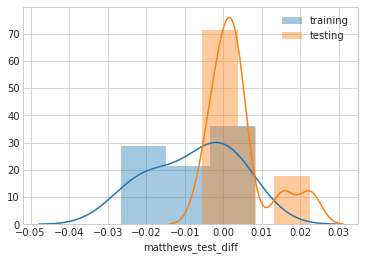

In [11]:
sns.distplot(df_all['matthews_diff'], label='training')
sns.distplot(df_all['matthews_test_diff'], label='testing')
plt.legend()

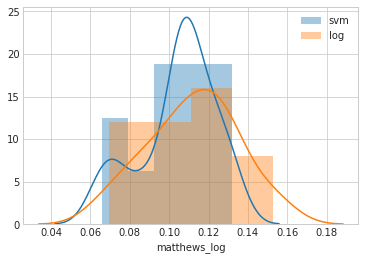

In [12]:
sns.distplot(df_all['matthews_svm'], label='svm')
sns.distplot(df_all['matthews_log'], label='log')
plt.legend()

In [13]:
df_all['matthews_diff'].median(), df_all['matthews_test_diff'].median()

(-0.004953713193017038, 0.0020190178365280115)

In [14]:
df_all['matthews_diff'].mean(), df_all['matthews_test_diff'].mean()

(-0.007628190351430507, 0.0038153578422084546)

In [15]:
len(df_all[df_all['matthews_svm'] > df_all['matthews_log']][all_columns]), len(df_all[df_all['test_matthews_svm'] > df_all['test_matthews_log']]), len(df_all)

(3, 8, 12)

In [16]:
df_all[df_all['test_matthews_svm'] < df_all['test_matthews_log']][all_columns]

,matthews_svm,matthews_log,test_matthews_svm,test_matthews_log,roc_auc_svm,roc_auc_log,test_roc_auc_svm,test_roc_auc_log,stock
4,0.110695,0.126845,0.097193,0.099164,0.554643,0.562416,0.548315,0.548906,9067
6,0.105389,0.105598,0.077847,0.079516,0.552433,0.552734,0.537941,0.539716,9058
10,0.073836,0.069389,0.071196,0.072696,0.536794,0.534545,0.535278,0.535818,11244
11,0.065681,0.086183,0.076827,0.082316,0.532622,0.543093,0.538405,0.541144,9062


In [17]:
len(df_all[df_all['roc_auc_svm'] > df_all['roc_auc_log']][all_columns]), len(df_all[df_all['test_roc_auc_svm'] > df_all['test_roc_auc_log']][all_columns]), len(df_all)

(2, 8, 12)

In [18]:
df_all[df_all['test_matthews_svm'] < df_all['test_matthews_log']][all_columns]

,matthews_svm,matthews_log,test_matthews_svm,test_matthews_log,roc_auc_svm,roc_auc_log,test_roc_auc_svm,test_roc_auc_log,stock
4,0.110695,0.126845,0.097193,0.099164,0.554643,0.562416,0.548315,0.548906,9067
6,0.105389,0.105598,0.077847,0.079516,0.552433,0.552734,0.537941,0.539716,9058
10,0.073836,0.069389,0.071196,0.072696,0.536794,0.534545,0.535278,0.535818,11244
11,0.065681,0.086183,0.076827,0.082316,0.532622,0.543093,0.538405,0.541144,9062


In [19]:
df_all[df_all['test_roc_auc_svm'] < df_all['test_roc_auc_log']][all_columns]

,matthews_svm,matthews_log,test_matthews_svm,test_matthews_log,roc_auc_svm,roc_auc_log,test_roc_auc_svm,test_roc_auc_log,stock
4,0.110695,0.126845,0.097193,0.099164,0.554643,0.562416,0.548315,0.548906,9067
6,0.105389,0.105598,0.077847,0.079516,0.552433,0.552734,0.537941,0.539716,9058
10,0.073836,0.069389,0.071196,0.072696,0.536794,0.534545,0.535278,0.535818,11244
11,0.065681,0.086183,0.076827,0.082316,0.532622,0.543093,0.538405,0.541144,9062
